## Analysis to investigate the mean snow depth for ASO lidar data between 3m and 50m product
* 3m data: compiled netCDFwith 3m topo.nc 
    * units = mm
    * mask: applied (in compiling step)
* 50m data: ascii files with 50m hetch mask
    * units = m
    * mask: APPLY HERE!

NOTE: masks do not pefectly line up, not ideal, but for size of dataset this should still produce useful initial results

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr


# import dask.array as da
# from dask.diagnostics import ProgressBar
# from dask.distributed import Client, LocalCluster

import matplotlib.patheffects as PathEffects

### load 3m data (xarray: compiled netCDF)

In [2]:
fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc' #ARS
# fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU

years = range(2013,2017) #2013-2017

#~~~~ ds full
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds.close 
ds

#~~~~~~~~~~~~~~ds subset
# dsubset = ds.sel(time=slice('2013','2017'))
# dsubset.close()

# ds = dsubset
# ds.close()
# ds

# dsmall = ds.sel(time='2018')
# dsmall.close()

# ds = dsmall
# ds.close()
# ds


<xarray.Dataset>
Dimensions:  (time: 51, x: 17569, y: 17002)
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    dem      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    veg      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Data variables:
    snow     (time, y, x) int16 dask.array<shape=(51, 17002, 17569), chunksize=(1, 1000, 1000)>

In [3]:
# drop 4/1/2016  & 7-27-2019 (tmp because 50m version needs extent fixing....)
#dlist = map(np.datetime64, ['2016-04-01', '2017-07-27'])  #function, [list of things]
ds = ds.drop([np.datetime64('2016-04-01'), np.datetime64('2017-07-27') ], dim='time')
ds

<xarray.Dataset>
Dimensions:  (time: 49, x: 17569, y: 17002)
Coordinates:
  * x        (x) float32 254007.0 254010.0 254013.0 ... 306708.0 306711.0
  * y        (y) float32 4230327.0 4230324.0 4230321.0 ... 4179327.0 4179324.0
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    dem      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
    veg      (y, x) float32 dask.array<shape=(17002, 17569), chunksize=(1000, 1000)>
Data variables:
    snow     (time, y, x) int16 dask.array<shape=(49, 17002, 17569), chunksize=(1, 1000, 1000)>

### dataframes 3m
compute means for 3m data and store in pd.DataFrame

In [4]:
# 3m means
means_3m=ds.snow.mean(dim=('x', 'y'))
means_3m = means_3m.values/10

#m3 means gt 0
means_3m_gt0 = ds.snow.where(ds.snow > 0).mean(dim=('x','y'))
means_3m_gt0 = means_3m_gt0.values/10

# three_m_df = pd.DataFrame(zip(means_3m, means_3m_gt0), columns = ['3m (cm)','3m>0 (cm)'], index = ds.time.dt.strftime('%Y-%m-%d'))
# three_m_df

## load 50m data (ascii files: downloaded from AH's published dataset on zenodo and ARS snow server)

In [5]:
depth_50m_years = list(range(2013,2018))

# #~~~ARS
# mask and DEM
mask_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/tuolx_hetchy_mask_50m.asc'
dem_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/tuolx_dem_50m.asc'

# ASO snow depth surfaces
depth_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/ASO_50m_depth_surfaces/asc/*.asc'

#~~~BSU
# base_path = '/Users/meganmason491/Documents/research/sierra/data/50m_analysis/'

# # mask and DEM
# mask_50m_path = base_path + 'tuolx_hetchy_mask_50m.asc'
# dem_50m_path = base_path + 'tuolx_dem_50m.asc'

# # ASO snow depth surfaces
# depth_50m_path = base_path + 'asc/*.asc'

In [6]:
# mask and DEM
mask_50m = np.loadtxt(mask_50m_path, skiprows=6)
dem_50m = np.loadtxt(dem_50m_path, skiprows=6)

#ASo snow depth surfaces 
flist = glob.glob(depth_50m_path)
flist = sorted(flist)
print('Number of files as input:', len(flist))

flight_dates = []

for f in sorted(flist):
    dt_str = f.split("/")[-1] #splits on '/' and saves the last one
    dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values for date info
    flight_dates.append(dt_str) #append to flight_date list

# flight_dates # flight dates as strings

flight_dates_dt = [datetime.strptime(flight_date, '%Y%m%d') for flight_date in flight_dates]


Number of files as input: 47


### dataframes 50m 
compute means for 50m data and store in pd.DataFrame

In [7]:
def mean_snow_depth(depth_array, convert_factor = 1e-3, mask_array = None, mask_value = None):
    '''
    Gets mean snow depth for ASO snow depth surfaces
        args:
            depth_array: numpy array from asc files
            dx: cellsize [m] in x direction
            dy: cellsize [m] in y direction
            convert_factor: (optional, default is 0.001 from mm to m)
            mask_array: (Optional) mask of the area for depth calculation
                       If no mask is provided will calculate for entire array
            mask_value: (Optional) value of the mask to calculate over
                       Default value will be any positive integer
           Note: depth_array and mask_array should cover the same extent 
                 and have the same dx,dy
       return:
           mean_depth: mean depth [m] over the area in mask
                       or the full area in the array if no mask is provided
    '''
    
    if mask_array is None:
        pass

        
    else:
        mean_depth = np.nanmean(depth_array[[(mask_array == mask_value) & (depth_array >= 0)]] * convert_factor)
        mean_depth_gt0 = np.nanmean(depth_array[[(mask_array == mask_value) & (depth_array > 0)]] * convert_factor)
#         sca = (depth_array[[(mask_array == mask_value) & (depth_array > 0)]].size / mask_array[mask_array == mask_value].size) * 100
        
    return mean_depth, mean_depth_gt0

In [8]:
means_50m = []
means_50m_gt0 = []

for f in sorted(flist):
    
    depth_array = np.loadtxt(f, skiprows=6) #load asc files
    mean_depth, mean_depth_gt0 = mean_snow_depth(depth_array, convert_factor=100, mask_array=mask_50m, mask_value=np.max(mask_50m)) #call mean_snow_depth function
    
    means_50m.append(mean_depth)
    means_50m_gt0.append(mean_depth_gt0)

    
# fifty_m_df = pd.DataFrame(zip(means_50m, means_50m_gt0), columns = ['50m (cm)','50m>0 (cm)'], index = ds.time.dt.strftime('%Y-%m-%d'))
# fifty_m_df
# NOTE, index equals xarray 3m

/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/meganmason/Documents/projects/thesis/analysis/virtual_envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


zip up dataframes

In [9]:
# df = pd.DataFrame(zip(means_3m_gt0.values/10, means_50m_gt0, means_3m.values/10, means_50m, flight_dates_dt), 
#                   columns = ['3m>0 (cm)', '50m>0 (cm)', '3m (cm)','50m (cm)', 'flight_dates (50m)'], 
#                   index = ds.time.dt.strftime('%Y-%m-%d'))
# df

df = pd.DataFrame(zip(means_3m_gt0, means_50m_gt0, means_3m, means_50m), 
                  columns = ['3m>0 (cm)', '50m>0 (cm)', '3m (cm)','50m (cm)']) #, 
#                   index = flight_dates_dt)
# df


In [10]:
df

# plt.plot_date(df['flight_dates (50m)'], df.columns[:-1], fmt='x', tz=None, xdate=True, ydate=False)

,3m>0 (cm),50m>0 (cm),3m (cm),50m (cm)
0,123.836449,85.614798,31.964225,72.699521
1,95.606067,58.932815,19.305326,43.849365
2,88.156068,50.580481,15.469975,35.120987
3,74.804510,34.667381,7.264973,16.465940
4,73.562370,30.639120,5.462887,12.356794
5,62.541330,20.481736,2.958338,6.683690
6,90.157070,63.251086,23.199672,52.796386
7,106.755478,81.929185,32.006653,72.813338
8,96.122020,70.692287,25.649601,58.329570
9,98.325670,64.892882,22.223776,50.508361


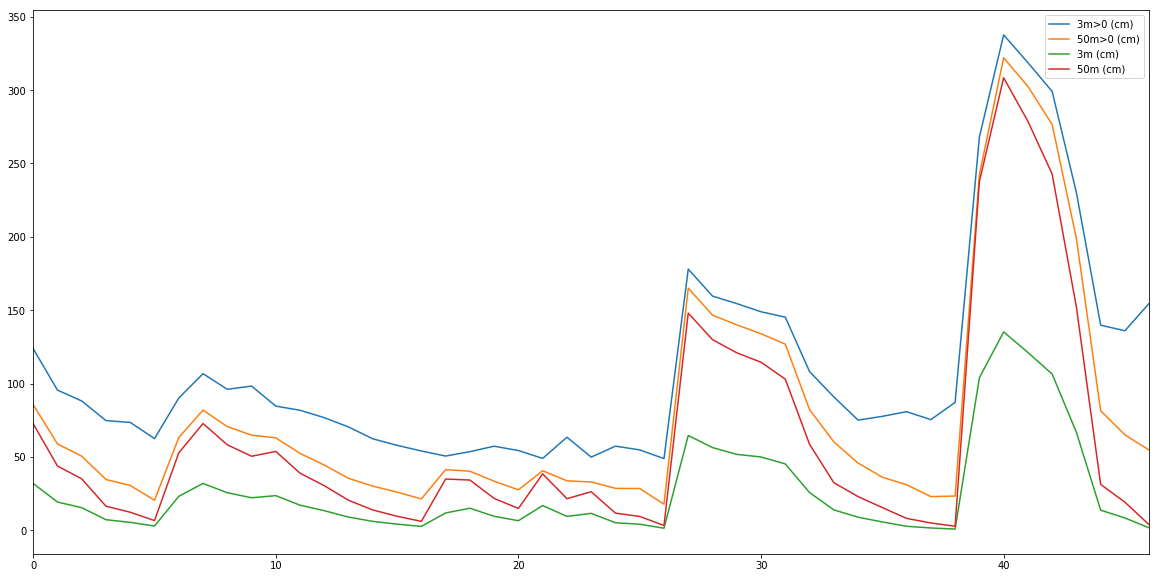

In [26]:
df.plot( figsize=(20,10))